# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)


cpu


In [51]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'
batch_dispersion = [2.0,2.0]
batch_level = [10,10]

In [132]:
batch_type = 'batch_specific_features'
batch_feature_frac = 0.1
# batch_type = 'batch_specific_features'
# batch_feature_frac = 1.0
# batch_type = 'variance_inflation'
# batch_dispersion = [1,4]
# batch_type = 'uniform_dropout'
# batch_level = [0.1,0.6]
# batch_type = 'downsampling'
# batch_level = [0.1,0.8]
batch_type = 'batch_specific_expression'
batch_level = [10.0, 10.0]
batch_feature_frac = 0.6
# batch_type = 'batch_specific_distribution'
# batch_distribution = ['normal','poisson']
# batch_level = [3.0, 5.0]
# batch_dispersion = [3, 3]
file_suffix = f"{time.strftime('%b%d-%H%M')}_{batch_type}_06"
file_suffix

'Apr21-1532_batch_specific_expression_06'

In [133]:
from concord.utils.simulation import Simulation

# Create an instance of the Simulation class

sim = Simulation(n_cells=1000, n_genes=100, n_batches=2, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=0,
                 state_dispersion=2.0, 
                 program_structure='linear_bidirectional',
                 program_on_time_fraction=0.1,
                 trajectory_program_num=5,
                 trajectory_cell_block_size_ratio=0.6,
                 trajectory_loop_to=None,
                 batch_distribution = batch_distribution,
                 batch_type=batch_type, 
                 batch_level=batch_level, 
                 batch_dispersion=batch_dispersion, 
                 batch_feature_frac = batch_feature_frac,
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()


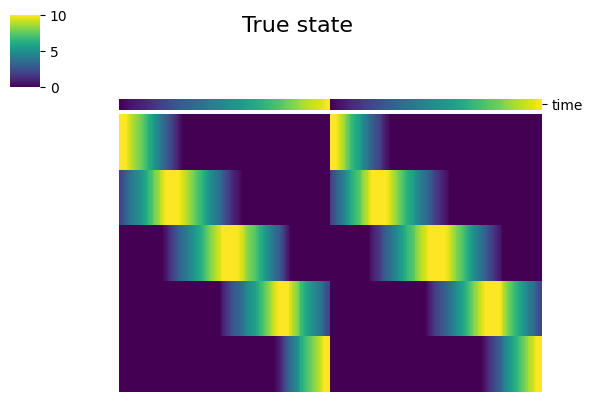

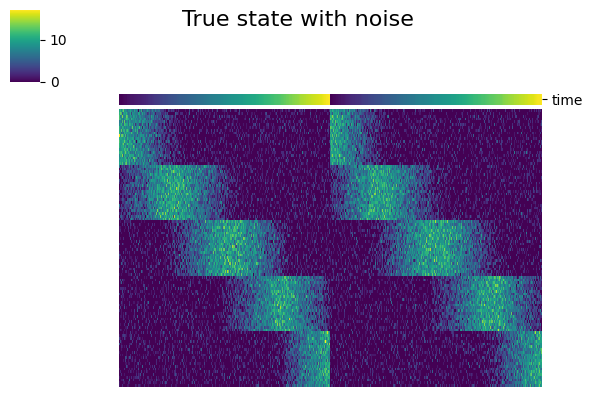

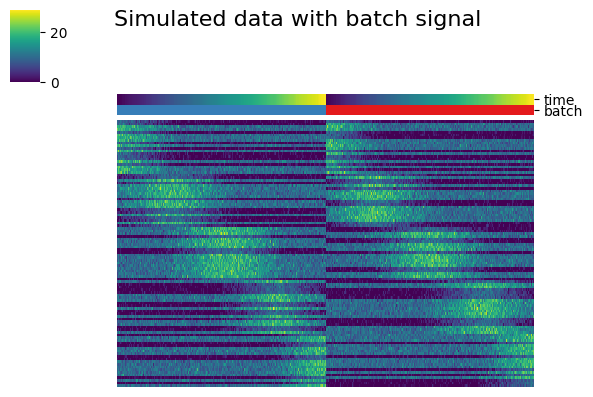

In [134]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### NO batch effect, noise added, PCA and UMAP

In [135]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

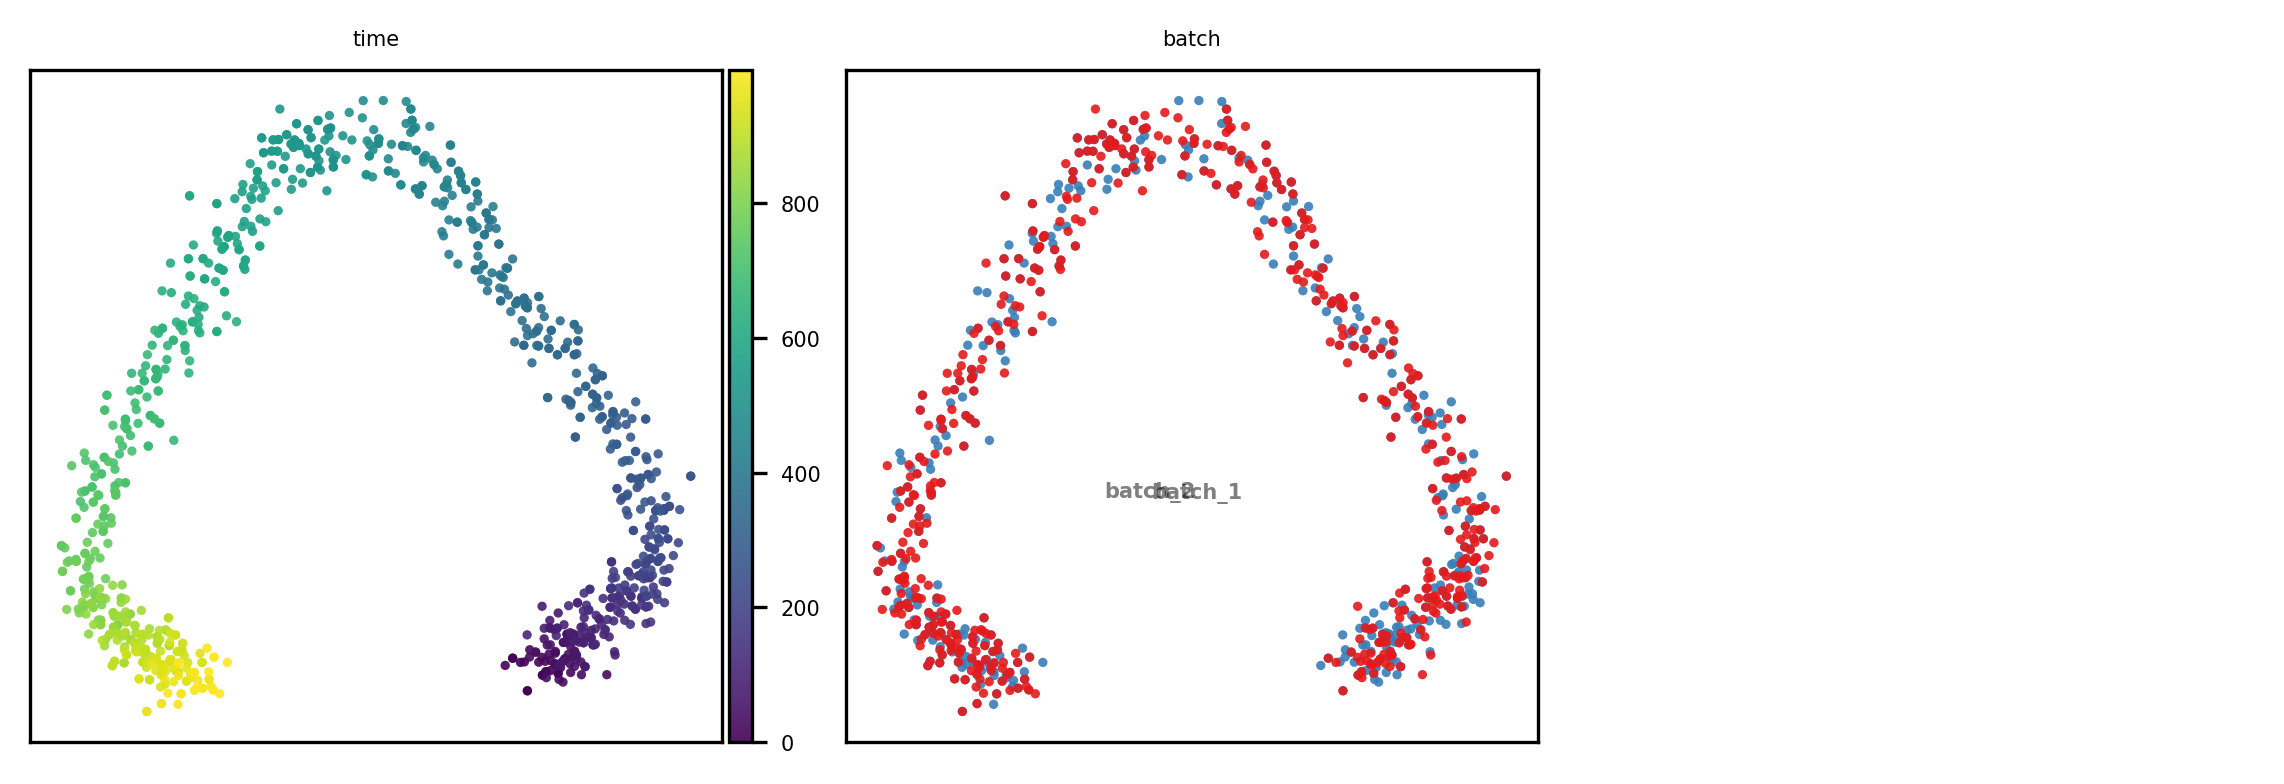

In [136]:
show_basis = 'PCA_wt_noise'
show_cols = [state_key, batch_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(7.5,2.5), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data', rasterized=False,
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.pdf"
)

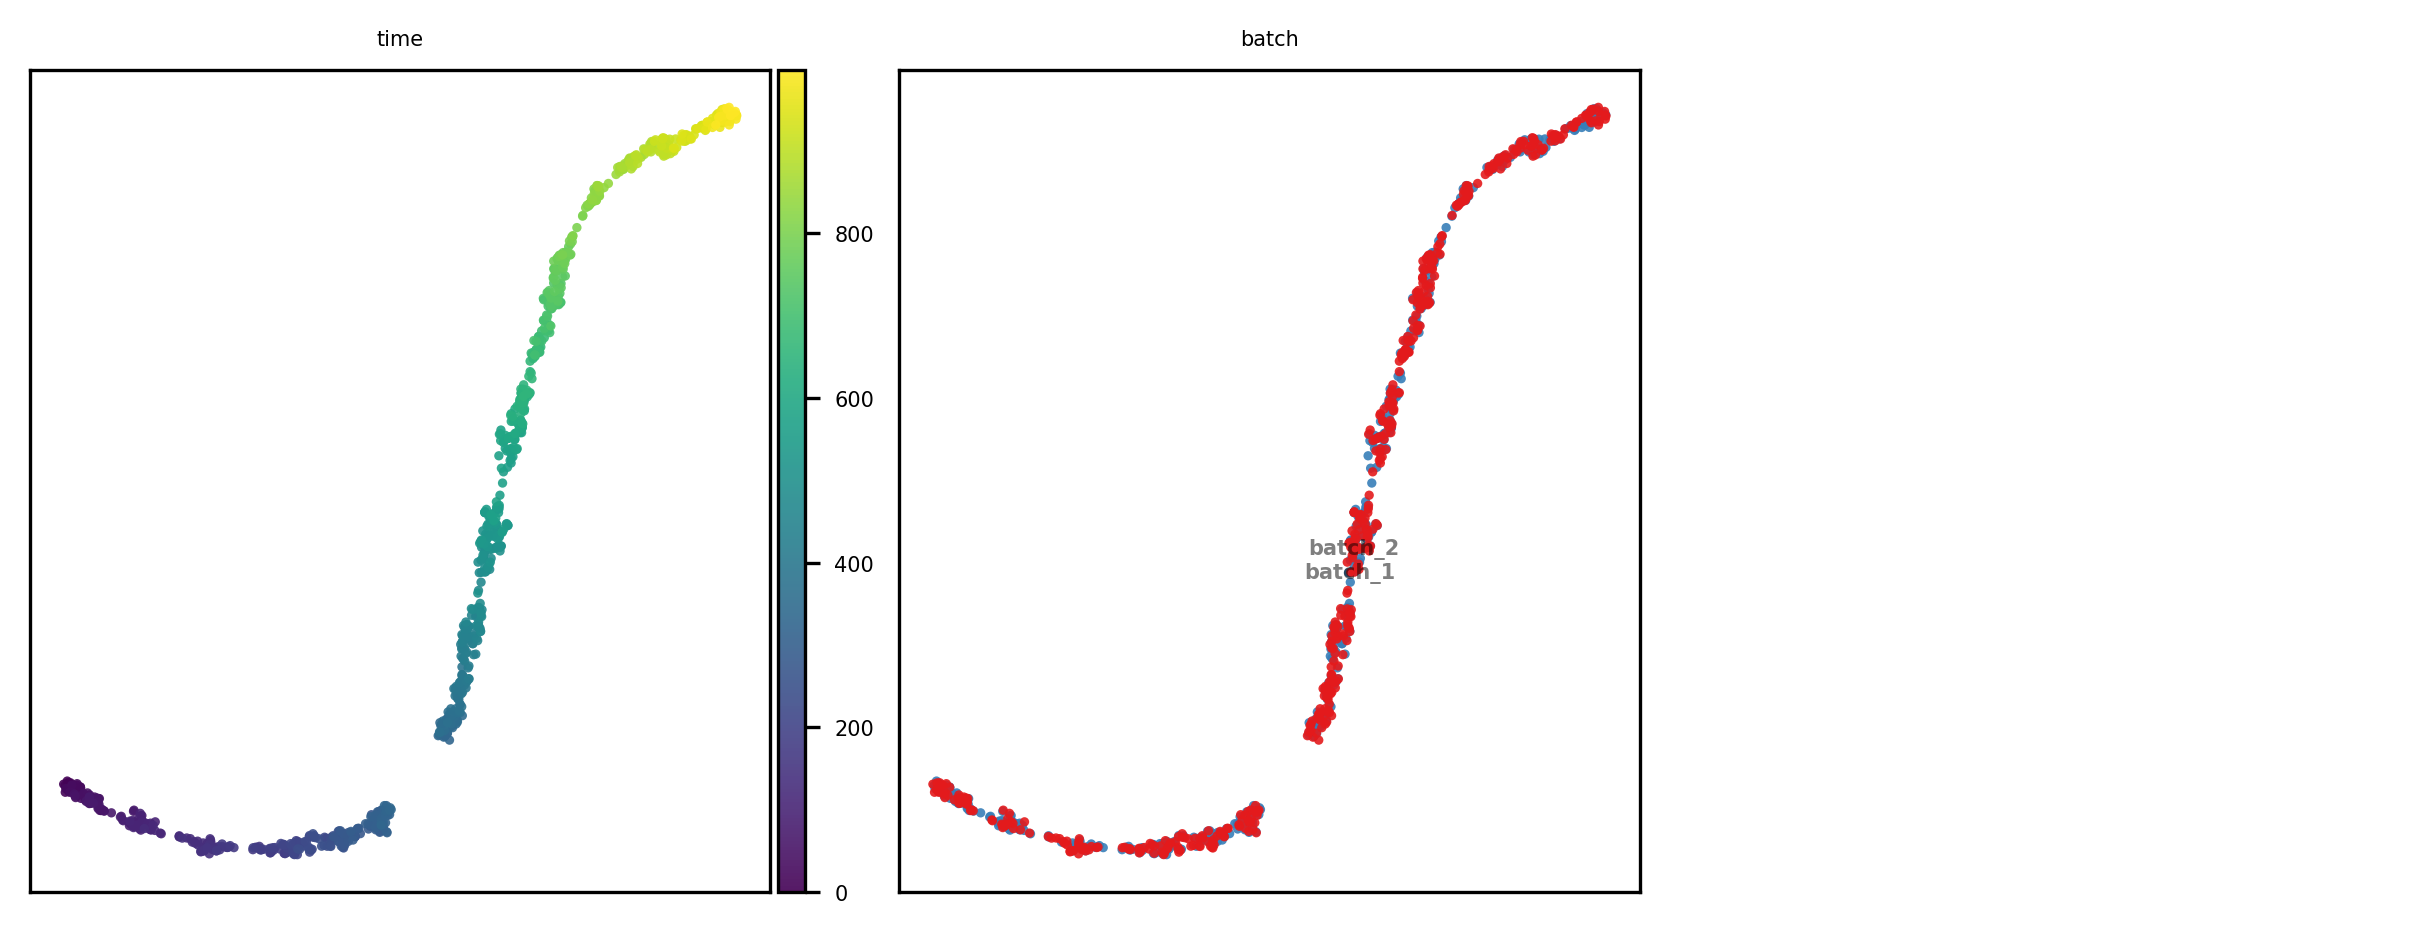

In [137]:
show_basis = 'UMAP_wt_noise'

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### No batch correction, PCA and UMAP

In [138]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

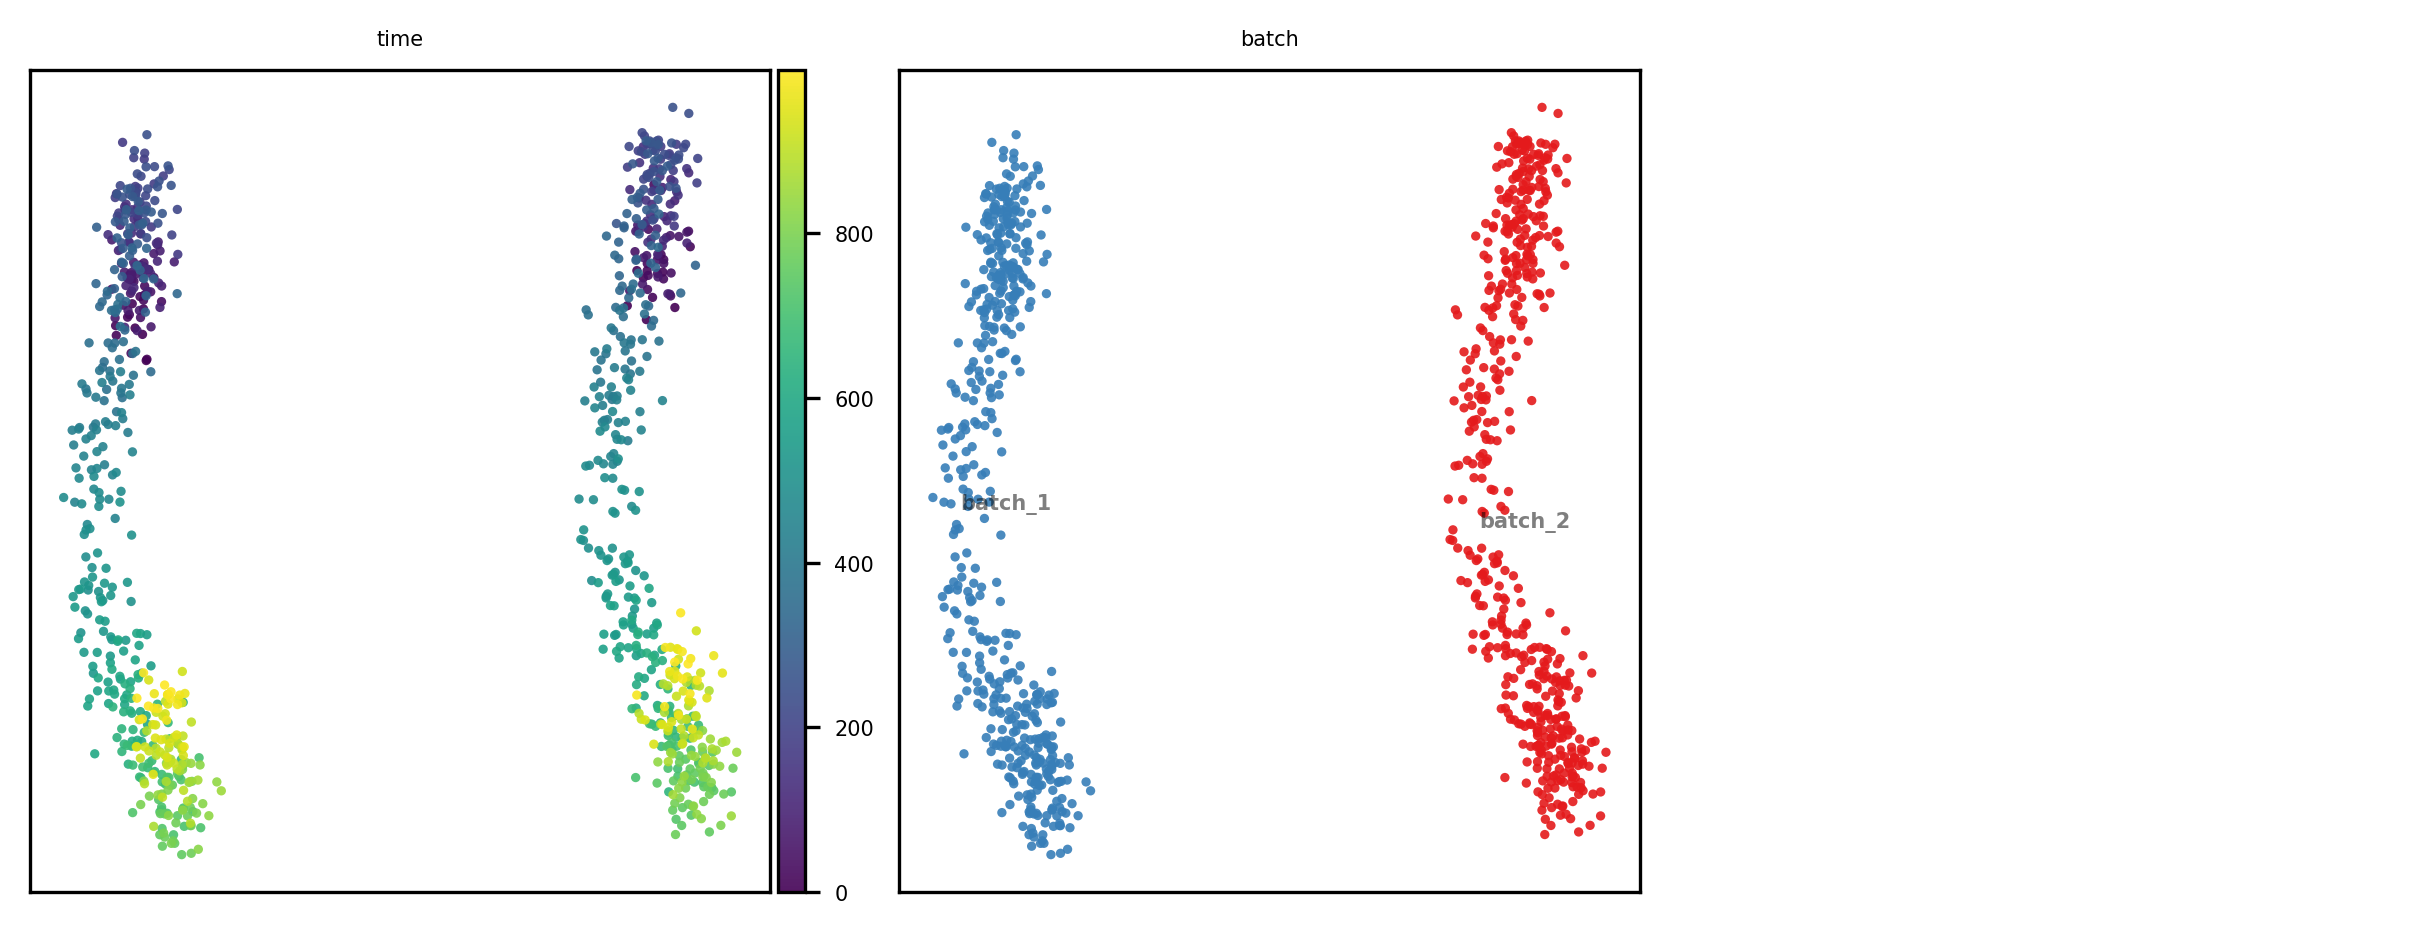

In [139]:
show_basis = 'X_pca'
show_cols = [state_key, batch_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

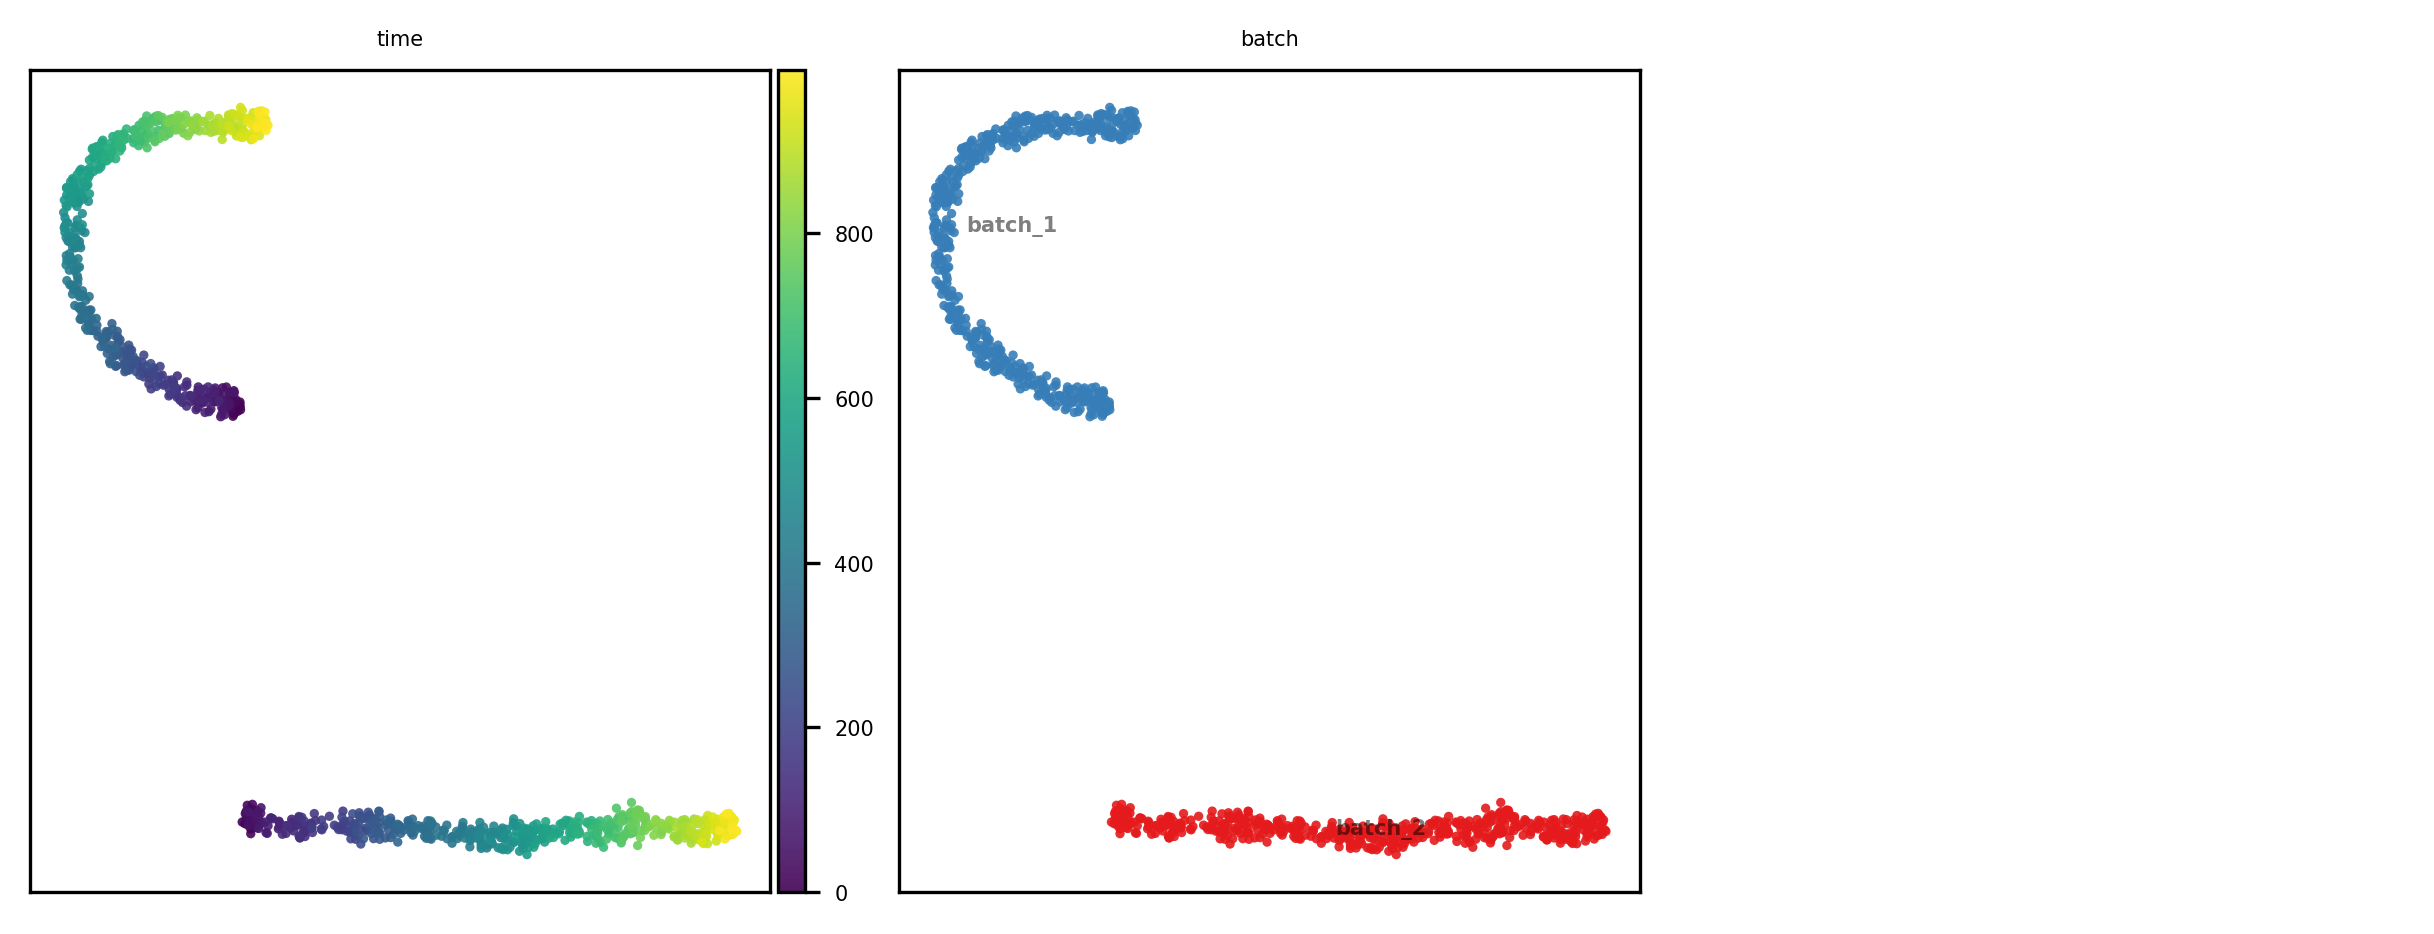

In [140]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

### Concord

In [141]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      p_intra_domain=.97, # intra-domain dropout probability
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'

cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 158.40it/s, loss=3.99]
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 219.73it/s, loss=3.48]


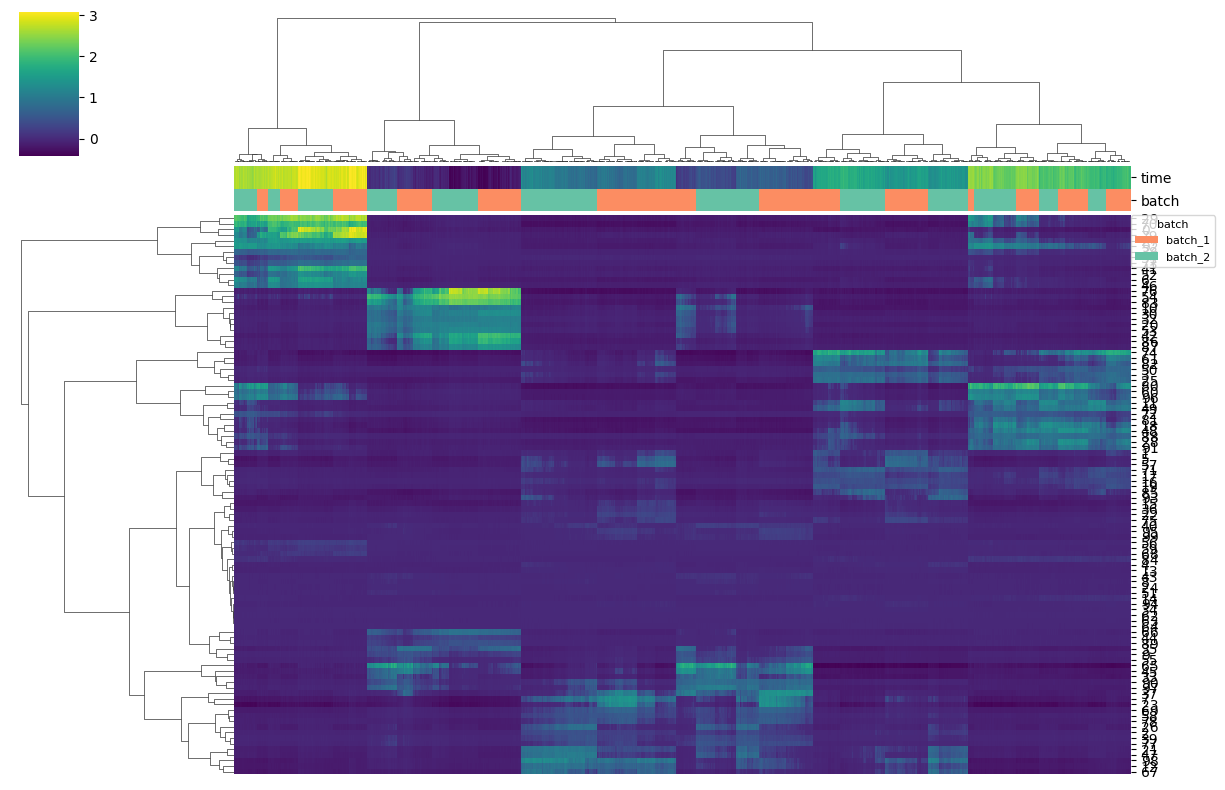

In [142]:
ccd.pl.heatmap_with_annotations(adata, val='Concord', obs_keys=[state_key, batch_key], 
                                cluster_cols=True, cluster_rows=True, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'Concord_latent_heatmap_{file_suffix}.png')

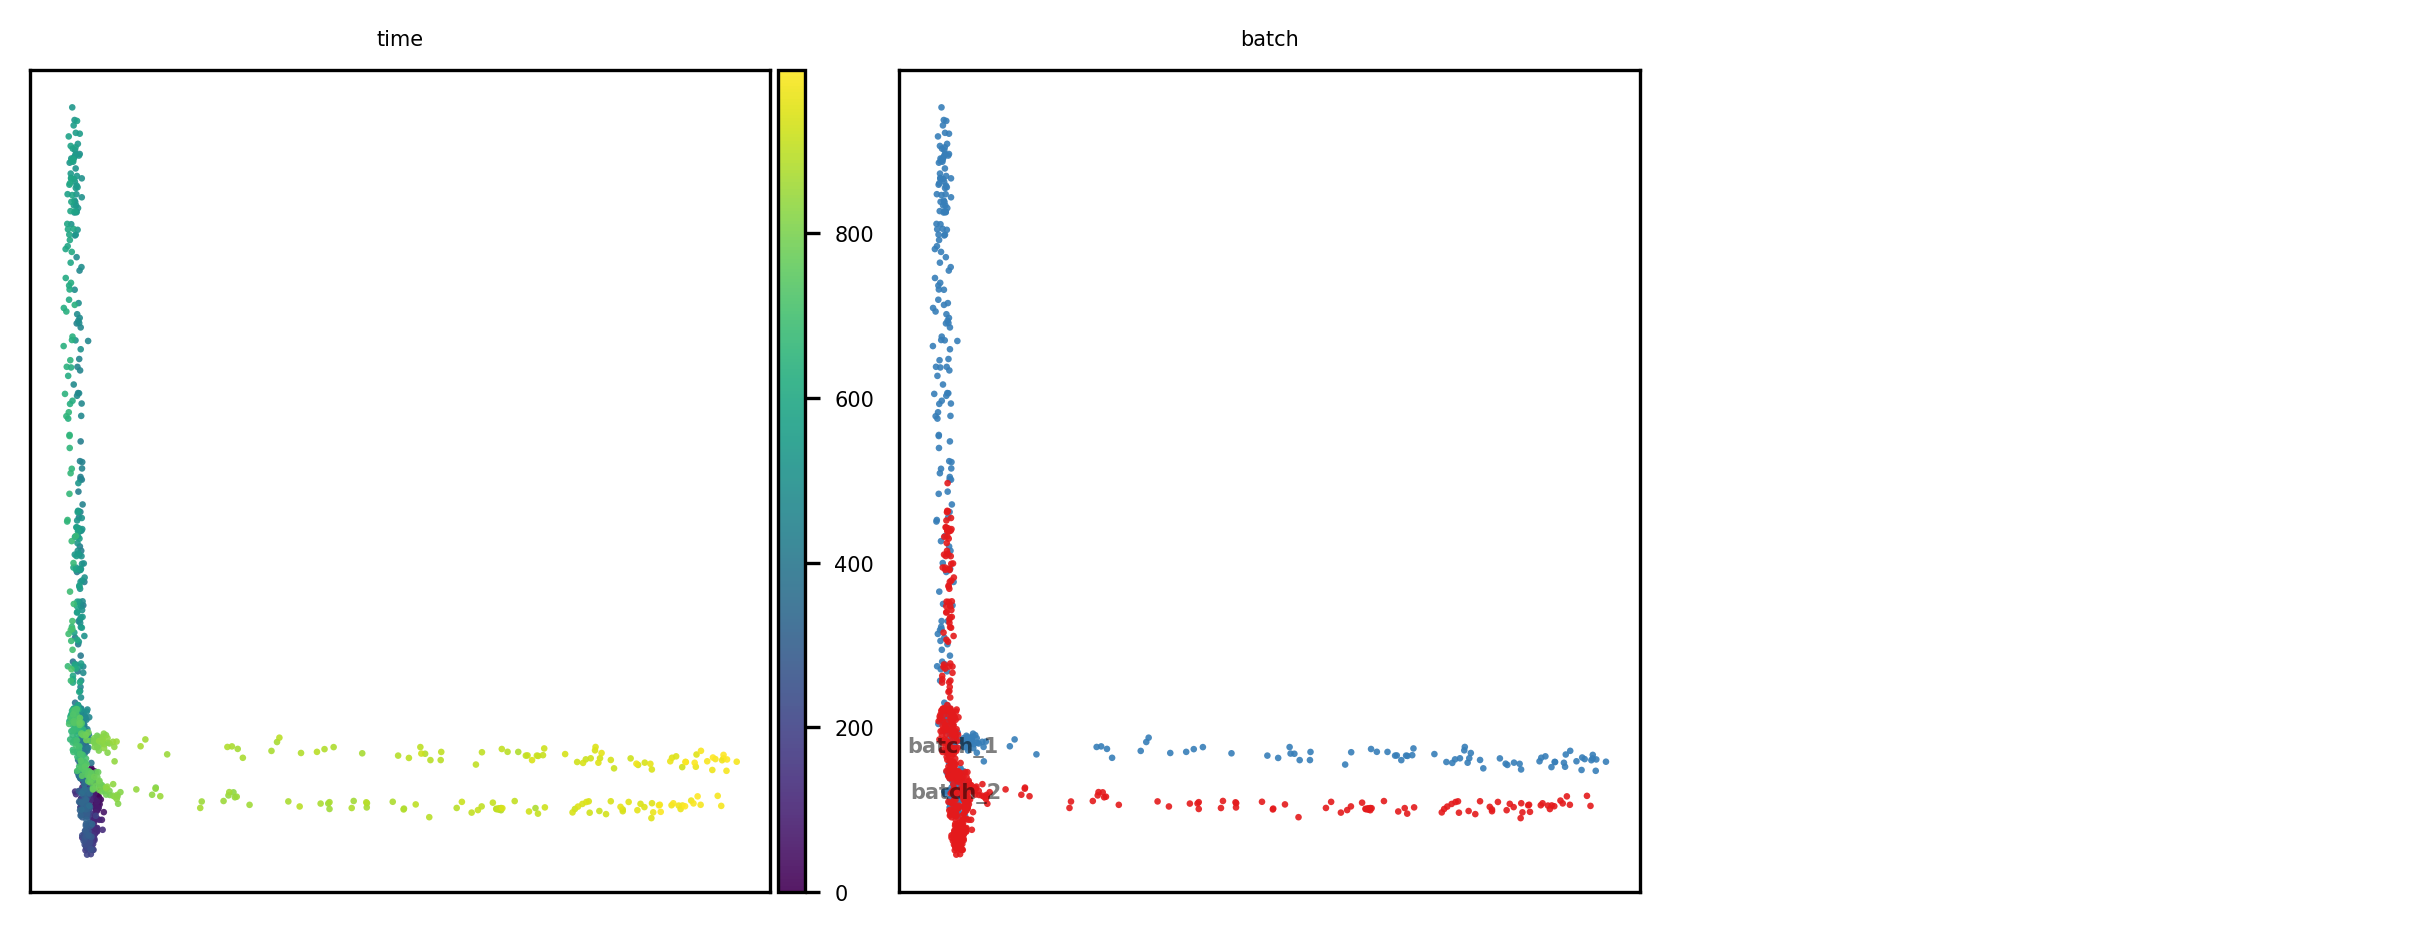

In [143]:
n_pc = min(adata.obsm[output_key].shape[1], adata.shape[0]) - 1
ccd.ul.run_pca(adata, source_key=output_key, result_key=f'{output_key}_PCA', n_pc=n_pc, random_state=seed)
show_basis = f'{output_key}'
show_cols = [state_key, batch_key]
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

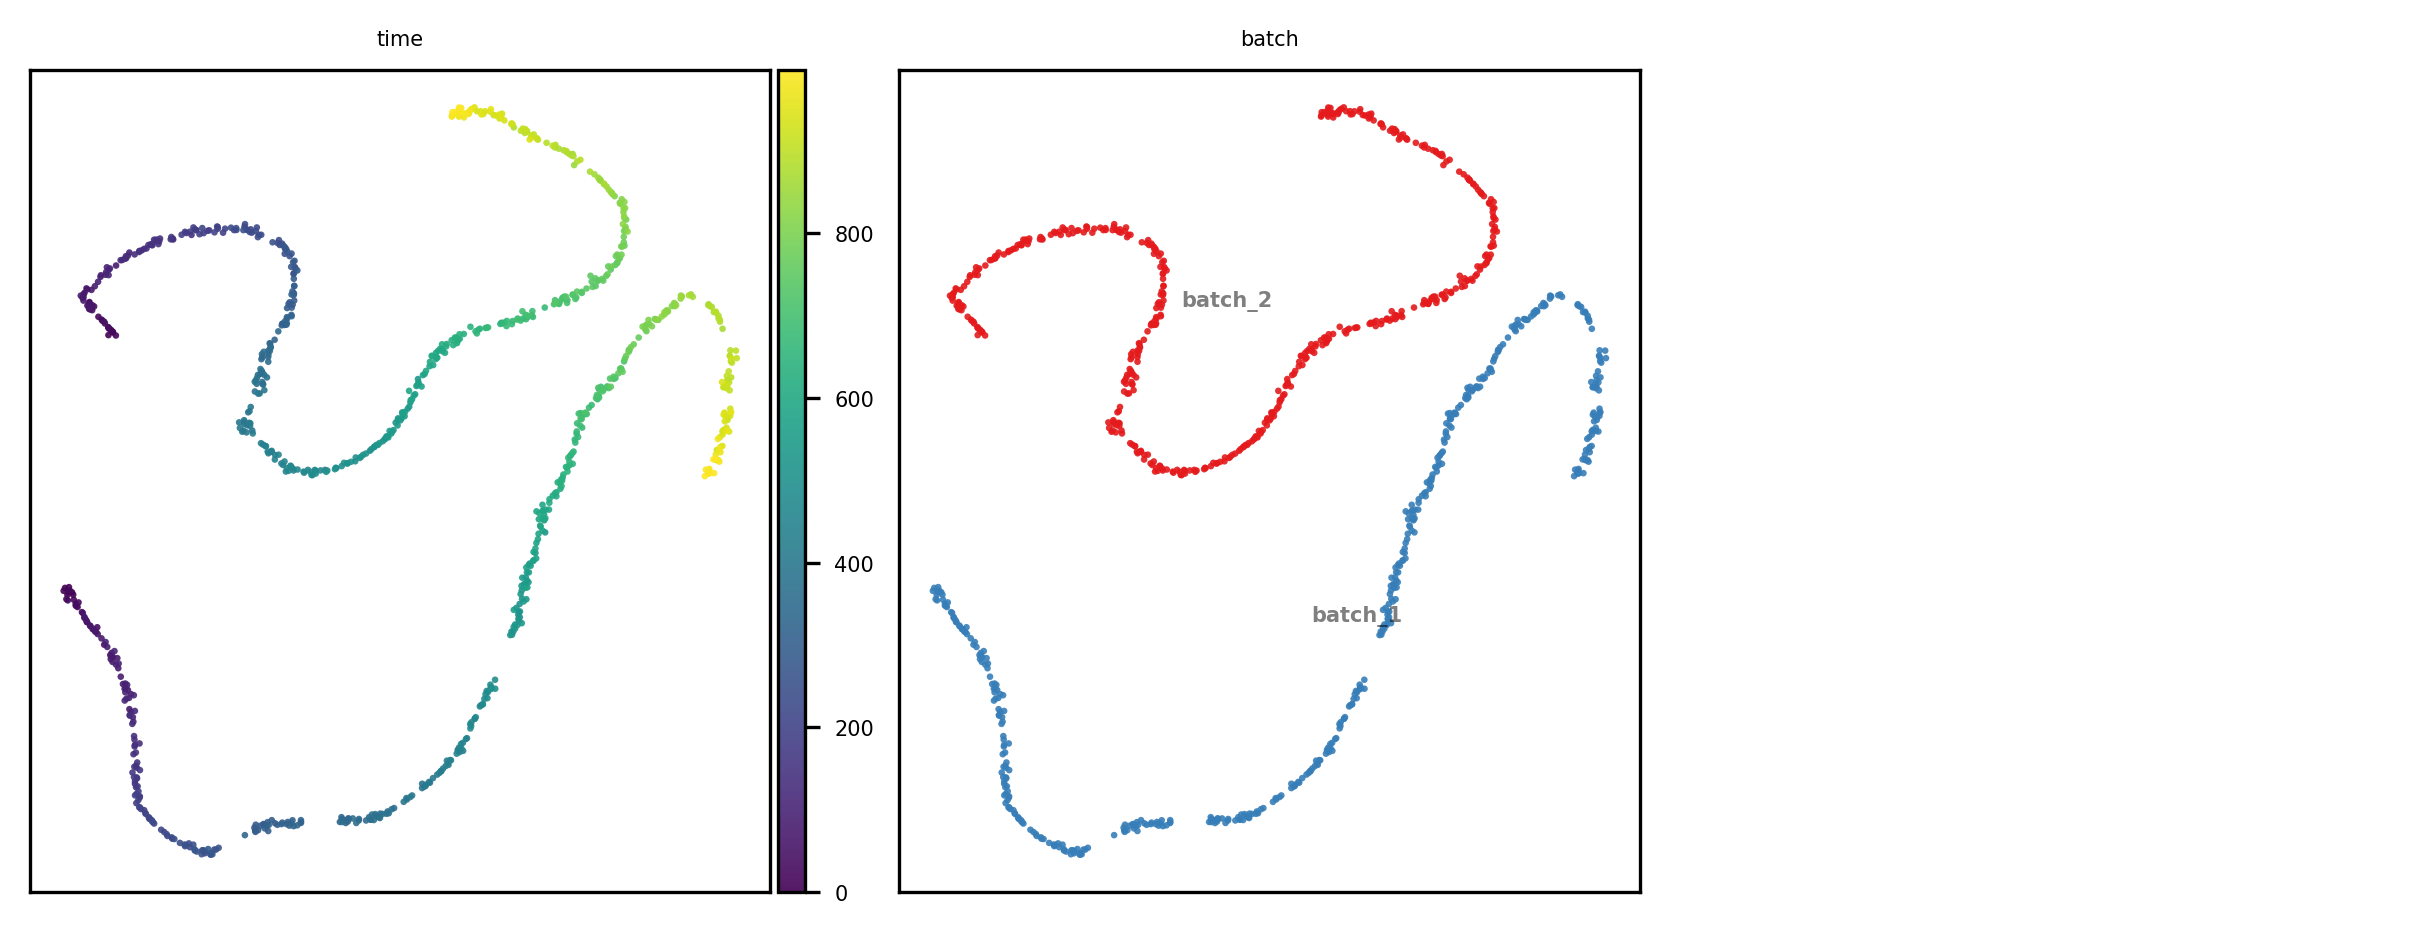

In [144]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep = 'Concord')
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key]
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)
